# Get home safe

---

Your problem is to reach the top of the mountain where you reside. You just realized that your car is under powered to climb. Luckily there's another mountain on the opposite side which can be used to gain momentum, and launch the car to the peak. You will use your Machine Learning approach to solve this problem.

**Mountain Car** is a classic control Reinforcement Learning problem that was first introduced by A. Moore in 1991 [1].

You will use AI Gym’s MountainCarContinuous-v0 variant to validate your theory.

**Details**

* **State:** Car’s horizontal position and velocity (can be negative).
* **Action:** Magnitude of push (if negative push to left, if positive push to right).
* **Reward:** +100 for reaching top of the right hand side mountain, minus the squared sum of actions from start to end.

<img src="./successful_policy.gif">

[1] A. Moore, Efficient Memory-Based Learning for Robot Control, PhD thesis, University of Cambridge, November 1990.


*This notebook is tested using ml.t3.medium notebook instance.*

*To keep things simple, the amount of time in each episode from Open AI Gym’s default of 200 environment steps is extended to 10,000 steps.*

*This notebook is based on the sample notebook available in https://github.com/aws/amazon-sagemaker-examples/*

## Task 1: Pre-requisites 

### Step 1: Imports

To get started, import the Python libraries you need, set up the environment with a few prerequisites for permissions and configurations.

In [2]:
import sagemaker
import boto3
import sys
import os
import glob
import re
import subprocess
import numpy as np
from IPython.display import HTML
import time
from time import gmtime, strftime

sys.path.append("common")
from misc import get_execution_role, wait_for_s3_object
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


### Step 2: Setup S3 bucket and define variables

Set up the linkage and authentication to the S3 bucket that you want to use for checkpoint and the metadata. 

In [3]:
# Get your bucket name with prifix 'get-home-safe-'
client = boto3.client('s3')
response = client.list_buckets()

for item in response.get('Buckets'):
    if re.search('get-home-safe-', item.get('Name')):
        s3_bucket = item.get('Name')

s3_output_path = "s3://{}/".format(s3_bucket)
print("S3 bucket path: {}".format(s3_output_path))

S3 bucket path: s3://get-home-safe-482211460703-342/


Define variables for the job prefix for the training jobs.

In [4]:
job_name_prefix = "get-home-safe"

### Step 3: Create an IAM role

Get the IAM role using `role = sagemaker.get_execution_role()`. 

`get_execution_role()` retrieves the IAM role from the notebook instance. You can then pass the role to run different tasks.

In [5]:
role = sagemaker.get_execution_role()
print("Using IAM role arn: {}".format(role))

Using IAM role arn: arn:aws:iam::482211460703:role/sagemaker_studio_role


## Task 2: Review the relevant functions and wrapper files.

### Step 1: Review patient_envs.py

A `src/patient_envs.py` file is created for the modified environments. Since you are using the Open AI Gym environment and wrappers, you need a function that takes the classic control environments `Continuous_MountainCarEnv` and wraps it with a `TimeLimit` that specifies the `max_episode_steps` to 10,000.

In [6]:
!pygmentize src/patient_envs.py

from gym.envs.classic_control.continuous_mountain_car import Continuous_MountainCarEnv
from gym.wrappers.time_limit import TimeLimit

def PatientContinuousMountainCar():
    env = Continuous_MountainCarEnv()
    return TimeLimit(env, max_episode_steps=10000)


### Step 2: Review the preset-mountain-car-continuous-clipped-ppo.py file 

The presets that configure the RL training jobs are defined in the "preset-mountain-car-continuous-clipped-ppo.py" file which is also uploaded on the /src directory. Also see "preset-mountain-car-dqn.py" for the discrete environment case. Using the preset file, you can define agent parameters to select the specific agent algorithm. You can also set the environment parameters, define the schedule and visualization parameters, and define the graph manager. The schedule presets will define the number of heat up steps, periodic evaluation steps, training steps between evaluations.

These can be overridden at runtime by specifying the RLCOACH_PRESET hyperparameter. Additionally, it can be used to define custom hyperparameters.

In [7]:
!pygmentize src/preset-mountain-car-continuous-clipped-ppo.py

from rl_coach.agents.clipped_ppo_agent import ClippedPPOAgentParameters
from rl_coach.architectures.layers import Dense
from rl_coach.base_parameters import PresetValidationParameters, VisualizationParameters
from rl_coach.core_types import (
    EnvironmentEpisodes,
    EnvironmentSteps,
    MaxDumpFilter,
    RunPhase,
    SelectedPhaseOnlyDumpFilter,
    TrainingSteps,
)
from rl_coach.environments.gym_environment import GymVectorEnvironment
from rl_coach.exploration_policies.e_greedy import EGreedyParameters
from rl_coach.filters.observation.observation_normalization_filter import (
    ObservationNormalizationFilter,
)
from rl_coach.graph_managers.basic_rl_graph_manager import BasicRLGraphManager
from rl_coach.graph_managers.graph_manager import ScheduleParameters
from rl_coach.schedules import LinearSchedule

####################
# Graph Scheduling #
####################

schedule_params = ScheduleParameters()
schedule_params.improve_steps = EnvironmentEpisodes(100)
schedule_param

### Step 3: Review the train-coach.py file

The training code is written in the file “train-coach.py” which is uploaded in the /src directory. 
We create a custom `SageMakerCoachPresetLauncher` which sets the default preset, maps and ties hyperparameters.

In [ ]:
!pygmentize src/train-coach.py

## Task 3: Train the RL model using the Python SDK Script mode

### Step 1: Create a training job


When using SageMaker for training, you can select a GPU or CPU instance. The RLEstimator is used for training RL jobs. 

1. Specify the source directory where the environment, presets and training code is uploaded.
2. Specify the entry point as the training code 
3. Specify the choice of RL toolkit and framework. This automatically resolves to the ECR path for the RL Container. 
4. Define the training parameters such as the instance count, job name, S3 path for output and job name. 
5. Specify the hyperparameters for the RL agent algorithm. The RLCOACH_PRESET can be used to specify the RL agent algorithm you want to use. 
6. Define the metrics definitions that you are interested in capturing in your logs. These can also be visualized in CloudWatch and SageMaker Notebooks. 

You are using variant of Proximal Policy Optimization (PPO) called Clipped PPO, which removes the need for complex KL divergence calculations.

In [9]:
# Define the instance type and epochs
instance_type = "ml.m5.xlarge"
epochs = 10
learning_rate = 0.005

# Define the training jobs parameters and hyper parameters.
estimator = RLEstimator(
    entry_point="train-coach.py",
    source_dir="src",
    dependencies=["common/sagemaker_rl"],
    toolkit=RLToolkit.COACH,
    toolkit_version="0.11.0",
    framework=RLFramework.MXNET,
    role=role,
    instance_type=instance_type,
    instance_count=1,
    output_path=s3_output_path,
    base_job_name=job_name_prefix,
    hyperparameters={
        "RLCOACH_PRESET": "preset-mountain-car-continuous-clipped-ppo",
        "discount": 0.995,
        "gae_lambda": 0.997,
        "evaluation_episodes": 3,
        "improve_steps": 100000,
        "training_freq_env_steps": 75000,
        "training_learning_rate": learning_rate,
        "training_batch_size": 256,
        "training_epochs": epochs,
        "save_model": 1,
    },
)

estimator.fit()

INFO:sagemaker:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker:Creating training-job with name: get-home-safe-2024-08-18-15-46-54-381


2024-08-18 15:46:54 Starting - Starting the training job...
2024-08-18 15:47:11 Starting - Preparing the instances for training...
2024-08-18 15:47:44 Downloading - Downloading input data...
2024-08-18 15:48:20 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-08-18 15:48:26,228 sagemaker-containers INFO     Imported framework sagemaker_mxnet_container.training
2024-08-18 15:48:26,232 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2024-08-18 15:48:26,247 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HP_GAE_LAMBDA': '0.997', 'SM_HP_TRAINING_EPOCHS': '10', 'SM_HP_IMPROVE_STEPS': '100000', 'SM_TRAINING_ENV': '{"additional_framework_parameters":{"sagemaker_estimator":"RLEstimator"},"channel_input_dirs":{},"current_host":"algo-1","framework_module":"sagemaker_mxnet_container.training:main","hosts":

### Step 2: Store intermediate training output and model checkpoints 

The output from the training job above is stored on S3. The intermediate folder contains gifs and metadata of the training.

In [10]:
job_name = estimator._current_job_name
print("Job name: {}".format(job_name))

s3_url = "s3://{}/{}".format(s3_bucket, job_name)

output_tar_key = "{}/output/output.tar.gz".format(job_name)

intermediate_folder_key = "{}/output/intermediate/".format(job_name)
output_url = "s3://{}/{}".format(s3_bucket, output_tar_key)
intermediate_url = "s3://{}/{}".format(s3_bucket, intermediate_folder_key)

print("S3 job path: {}".format(s3_url))
print("Output.tar.gz location: {}".format(output_url))
print("Intermediate folder path: {}".format(intermediate_url))

tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))

Job name: get-home-safe-2024-08-18-15-46-54-381
S3 job path: s3://get-home-safe-482211460703-342/get-home-safe-2024-08-18-15-46-54-381
Output.tar.gz location: s3://get-home-safe-482211460703-342/get-home-safe-2024-08-18-15-46-54-381/output/output.tar.gz
Intermediate folder path: s3://get-home-safe-482211460703-342/get-home-safe-2024-08-18-15-46-54-381/output/intermediate/
Create local folder /tmp/get-home-safe-2024-08-18-15-46-54-381


## Task 4: Visualization

### Step 1: Plot metrics for training job
We can pull the reward metric of the training and plot it to see the performance of the model over time.

Note: you may need to restart the kernel to use updated packages.


INFO:matplotlib.font_manager:generated new fontManager


Waiting for s3://get-home-safe-482211460703-342/get-home-safe-2024-08-18-15-46-54-381/output/intermediate/worker_0.simple_rl_graph.main_level.main_level.agent_0.csv...


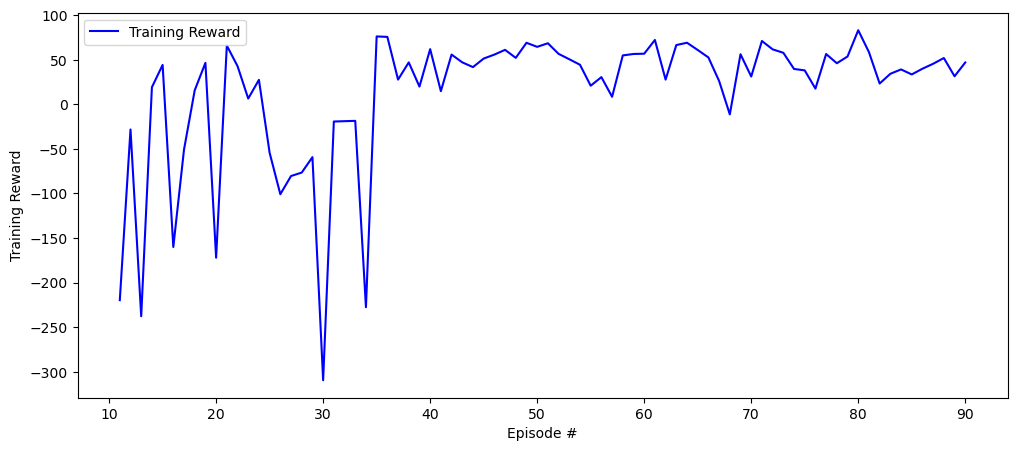

In [11]:
%pip install matplotlib
%matplotlib inline
import pandas as pd

csv_file_name = "worker_0.simple_rl_graph.main_level.main_level.agent_0.csv"
key = os.path.join(intermediate_folder_key, csv_file_name)
wait_for_s3_object(s3_bucket, key, tmp_dir)

csv_file = "{}/{}".format(tmp_dir, csv_file_name)
df = pd.read_csv(csv_file)
df = df.dropna(subset=["Training Reward"])
x_axis = "Episode #"
y_axis = "Training Reward"

if len(df) > 0:
    plt = df.plot(x=x_axis, y=y_axis, figsize=(12, 5), legend=True, style="b-")
    plt.set_ylabel(y_axis)
    plt.set_xlabel(x_axis)

### Step 2: Visualize the rendered gifs
The latest gif file found in the gifs directory is displayed. You can replace the tmp.gif file below to visualize other files generated.

In [12]:
key = os.path.join(intermediate_folder_key, "gifs")
wait_for_s3_object(s3_bucket, key, tmp_dir)
print("Copied gifs files to {}".format(tmp_dir))

Waiting for s3://get-home-safe-482211460703-342/get-home-safe-2024-08-18-15-46-54-381/output/intermediate/gifs...
Copied gifs files to /tmp/get-home-safe-2024-08-18-15-46-54-381


In [13]:
glob_pattern = os.path.join("{}/*.gif".format(tmp_dir))
gifs = [file for file in glob.iglob(glob_pattern, recursive=True)]
extract_episode = lambda string: int(
    re.search(".*episode-(\d*)_.*", string, re.IGNORECASE).group(1)
)
gifs.sort(key=extract_episode)
print("GIFs found:\n{}".format("\n".join([os.path.basename(gif) for gif in gifs])))

GIFs found:
2024-08-18-15-52-36_episode-34_score--30.415022151915508.gif
2024-08-18-15-53-32_episode-35_score-71.04134559772602.gif
2024-08-18-15-57-36_episode-98_score-93.32793855777308.gif
2024-08-18-15-57-51_episode-100_score-96.17374737139485.gif


In [14]:
# visualize a specific episode
gif_index = -1  # since you want last gif
gif_filepath = gifs[gif_index]
gif_filename = os.path.basename(gif_filepath)
print("Selected GIF: {}".format(gif_filename))
os.system("mkdir -p ./src/tmp/ && cp {} ./src/tmp/{}.gif".format(gif_filepath, gif_filename))
HTML('<img src="./src/tmp/{}.gif">'.format(gif_filename))

Selected GIF: 2024-08-18-15-57-51_episode-100_score-96.17374737139485.gif


## Task 5: Model deployment

Since you specified MXNet when configuring the RLEstimator, the MXNet deployment container will be used for hosting.

In [15]:
predictor = estimator.deploy(
    initial_instance_count=1, instance_type='ml.m5.large', entry_point="deploy-mxnet-coach.py"
)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-482211460703
INFO:sagemaker:Creating model with name: get-home-safe-2024-08-18-16-00-52-692
INFO:sagemaker:Creating endpoint-config with name get-home-safe-2024-08-18-16-00-52-692
INFO:sagemaker:Creating endpoint with name get-home-safe-2024-08-18-16-00-52-692


------!

You can test the endpoint with 2 samples observations. Starting with the car on the right side, but starting to fall back down the hill.

In [16]:
output = predictor.predict(np.array([0.5, -0.5]))
action = output[1][0]
action

[0.06238524615764618]

You will see the policy decides to move the car to the left (negative value). And similarly in the other direction.

In [17]:
output = predictor.predict(np.array([-0.5, 0.5]))
action = output[1][0]
action

[0.2715073227882385]

### Clean up endpoint

In [ ]:
#predictor.delete_endpoint()